In [1]:
import os
import pandas as pd
import numpy as np
np.set_printoptions(precision=4)
import catboost
print(catboost.__version__)
from jupyterthemes import jtplot
jtplot.style('default')
!jupyter nbextension enable --py widgetsnbextension

1.0.0
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
from catboost.datasets import amazon

(train_df, test_df) = amazon()

In [3]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
y = train_df.ACTION
x = train_df.drop('ACTION', axis=1)

In [5]:
cat_features = list(range(0, len(x.columns)))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [6]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y)-sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


This is preety unbalanced

Now lets train our model

In [7]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=100)  # we are training for 100 trees
model.fit(x, y, cat_features=cat_features, verbose=10)

# cat_features=cat_features is passing the index of the columns
# you can also give columns name if yu want to use strings
# But that will be quit a work :)

Learning rate set to 0.377604
0:	learn: 0.4528598	total: 113ms	remaining: 11.2s
10:	learn: 0.1744186	total: 187ms	remaining: 1.51s
20:	learn: 0.1676119	total: 257ms	remaining: 965ms
30:	learn: 0.1652446	total: 313ms	remaining: 696ms
40:	learn: 0.1633644	total: 369ms	remaining: 531ms
50:	learn: 0.1621892	total: 437ms	remaining: 420ms
60:	learn: 0.1609164	total: 493ms	remaining: 315ms
70:	learn: 0.1594572	total: 548ms	remaining: 224ms
80:	learn: 0.1585876	total: 604ms	remaining: 142ms
90:	learn: 0.1573593	total: 670ms	remaining: 66.3ms
99:	learn: 0.1566977	total: 723ms	remaining: 0us


In [8]:
model.predict_proba(x)

array([[0.0098, 0.9902],
       [0.0101, 0.9899],
       [0.0579, 0.9421],
       ...,
       [0.0118, 0.9882],
       [0.1891, 0.8109],
       [0.0235, 0.9765]])

This is good, if we remove the n_iteration then by default it will be set as 1000\
But, in the imbalnce  dataset sometimes you add the extra columns weight\
large weight for the rare class and small weight for the very frequent class\
or somethime you might have something else like group id like we have for some modes

If you have lot of information then yu can create a pool class

In [9]:
from catboost import Pool
pool = Pool(data=x, label=y, cat_features=cat_features)

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

train_pool = Pool(
                    data = x_train,
                    label = y_train,
                    cat_features = cat_features
)

val_pool = Pool(
                    data = x_val,
                    label = y_val,
                    cat_features = cat_features
)

Now, there are 2 objective function available\
1. Logloss: for binary target\
2. CrossEntropy: for probabilities in target\
\
It will be selected automatically

In [11]:
model = CatBoostClassifier(
                            iterations = 5,
                            learning_rate = 0.1
)

model.fit(train_pool, eval_set = val_pool, verbose = 1)

print('Model is fittef: {}'.format(model.is_fitted()))
print('Model params: \n{}'.format(model.get_params()))

0:	learn: 0.6189489	test: 0.6187790	best: 0.6187790 (0)	total: 7.32ms	remaining: 29.3ms
1:	learn: 0.5585414	test: 0.5579742	best: 0.5579742 (1)	total: 15.4ms	remaining: 23ms
2:	learn: 0.5083288	test: 0.5075307	best: 0.5075307 (2)	total: 19.1ms	remaining: 12.8ms
3:	learn: 0.4661280	test: 0.4649882	best: 0.4649882 (3)	total: 23.4ms	remaining: 5.86ms
4:	learn: 0.4305277	test: 0.4291119	best: 0.4291119 (4)	total: 27.6ms	remaining: 0us

bestTest = 0.4291119343
bestIteration = 4

Model is fittef: True
Model params: 
{'iterations': 5, 'learning_rate': 0.1}


Oofcourse we wil not use iteration = 5 in real world :)

In [12]:
model = CatBoostClassifier(
                            iterations = 1000
)

model.fit(train_pool, eval_set = val_pool)

Learning rate set to 0.071005
0:	learn: 0.6102933	test: 0.6097438	best: 0.6097438 (0)	total: 20.4ms	remaining: 20.4s
1:	learn: 0.5396455	test: 0.5376447	best: 0.5376447 (1)	total: 38.2ms	remaining: 19s
2:	learn: 0.4846008	test: 0.4825247	best: 0.4825247 (2)	total: 45.5ms	remaining: 15.1s
3:	learn: 0.4389560	test: 0.4368027	best: 0.4368027 (3)	total: 51.5ms	remaining: 12.8s
4:	learn: 0.4001715	test: 0.3979680	best: 0.3979680 (4)	total: 71ms	remaining: 14.1s
5:	learn: 0.3690323	test: 0.3667915	best: 0.3667915 (5)	total: 84.1ms	remaining: 13.9s
6:	learn: 0.3438560	test: 0.3415709	best: 0.3415709 (6)	total: 91ms	remaining: 12.9s
7:	learn: 0.3216339	test: 0.3190762	best: 0.3190762 (7)	total: 101ms	remaining: 12.5s
8:	learn: 0.3014963	test: 0.2978330	best: 0.2978330 (8)	total: 118ms	remaining: 13s
9:	learn: 0.2851202	test: 0.2812826	best: 0.2812826 (9)	total: 133ms	remaining: 13.2s
10:	learn: 0.2696478	test: 0.2651098	best: 0.2651098 (10)	total: 149ms	remaining: 13.4s
11:	learn: 0.2611625	te

98:	learn: 0.1540130	test: 0.1367357	best: 0.1367283 (97)	total: 2.92s	remaining: 26.6s
99:	learn: 0.1538844	test: 0.1366351	best: 0.1366351 (99)	total: 2.98s	remaining: 26.8s
100:	learn: 0.1538627	test: 0.1366280	best: 0.1366280 (100)	total: 3s	remaining: 26.7s
101:	learn: 0.1538465	test: 0.1366102	best: 0.1366102 (101)	total: 3.03s	remaining: 26.7s
102:	learn: 0.1537935	test: 0.1365734	best: 0.1365734 (102)	total: 3.06s	remaining: 26.7s
103:	learn: 0.1537262	test: 0.1365485	best: 0.1365485 (103)	total: 3.1s	remaining: 26.7s
104:	learn: 0.1536823	test: 0.1365459	best: 0.1365459 (104)	total: 3.14s	remaining: 26.7s
105:	learn: 0.1536309	test: 0.1364984	best: 0.1364984 (105)	total: 3.17s	remaining: 26.7s
106:	learn: 0.1535295	test: 0.1364916	best: 0.1364916 (106)	total: 3.2s	remaining: 26.7s
107:	learn: 0.1534206	test: 0.1364122	best: 0.1364122 (107)	total: 3.24s	remaining: 26.8s
108:	learn: 0.1533048	test: 0.1364313	best: 0.1364122 (107)	total: 3.27s	remaining: 26.7s
109:	learn: 0.15330

196:	learn: 0.1460851	test: 0.1338505	best: 0.1338373 (195)	total: 6.13s	remaining: 25s
197:	learn: 0.1460341	test: 0.1338093	best: 0.1338093 (197)	total: 6.17s	remaining: 25s
198:	learn: 0.1459501	test: 0.1337806	best: 0.1337806 (198)	total: 6.2s	remaining: 24.9s
199:	learn: 0.1457813	test: 0.1337487	best: 0.1337487 (199)	total: 6.24s	remaining: 25s
200:	learn: 0.1457584	test: 0.1337447	best: 0.1337447 (200)	total: 6.26s	remaining: 24.9s
201:	learn: 0.1457052	test: 0.1337413	best: 0.1337413 (201)	total: 6.28s	remaining: 24.8s
202:	learn: 0.1456095	test: 0.1337574	best: 0.1337413 (201)	total: 6.31s	remaining: 24.8s
203:	learn: 0.1455124	test: 0.1338264	best: 0.1337413 (201)	total: 6.35s	remaining: 24.8s
204:	learn: 0.1453938	test: 0.1337945	best: 0.1337413 (201)	total: 6.39s	remaining: 24.8s
205:	learn: 0.1453578	test: 0.1337868	best: 0.1337413 (201)	total: 6.42s	remaining: 24.7s
206:	learn: 0.1453316	test: 0.1337733	best: 0.1337413 (201)	total: 6.44s	remaining: 24.7s
207:	learn: 0.145

292:	learn: 0.1393071	test: 0.1328014	best: 0.1327812 (289)	total: 8.97s	remaining: 21.6s
293:	learn: 0.1392616	test: 0.1328105	best: 0.1327812 (289)	total: 9.01s	remaining: 21.6s
294:	learn: 0.1391860	test: 0.1327843	best: 0.1327812 (289)	total: 9.04s	remaining: 21.6s
295:	learn: 0.1391389	test: 0.1327229	best: 0.1327229 (295)	total: 9.06s	remaining: 21.6s
296:	learn: 0.1390828	test: 0.1326840	best: 0.1326840 (296)	total: 9.09s	remaining: 21.5s
297:	learn: 0.1390582	test: 0.1326813	best: 0.1326813 (297)	total: 9.11s	remaining: 21.5s
298:	learn: 0.1389615	test: 0.1325477	best: 0.1325477 (298)	total: 9.15s	remaining: 21.5s
299:	learn: 0.1389067	test: 0.1325203	best: 0.1325203 (299)	total: 9.19s	remaining: 21.4s
300:	learn: 0.1388004	test: 0.1324915	best: 0.1324915 (300)	total: 9.22s	remaining: 21.4s
301:	learn: 0.1387658	test: 0.1324994	best: 0.1324915 (300)	total: 9.24s	remaining: 21.4s
302:	learn: 0.1387137	test: 0.1324464	best: 0.1324464 (302)	total: 9.27s	remaining: 21.3s
303:	learn

388:	learn: 0.1338396	test: 0.1322726	best: 0.1322389 (385)	total: 12s	remaining: 18.9s
389:	learn: 0.1338395	test: 0.1322725	best: 0.1322389 (385)	total: 12.1s	remaining: 18.9s
390:	learn: 0.1337910	test: 0.1322383	best: 0.1322383 (390)	total: 12.1s	remaining: 18.8s
391:	learn: 0.1337175	test: 0.1322045	best: 0.1322045 (391)	total: 12.1s	remaining: 18.8s
392:	learn: 0.1336532	test: 0.1322045	best: 0.1322045 (391)	total: 12.1s	remaining: 18.7s
393:	learn: 0.1336009	test: 0.1321680	best: 0.1321680 (393)	total: 12.2s	remaining: 18.7s
394:	learn: 0.1335965	test: 0.1321722	best: 0.1321680 (393)	total: 12.2s	remaining: 18.7s
395:	learn: 0.1335401	test: 0.1321458	best: 0.1321458 (395)	total: 12.2s	remaining: 18.6s
396:	learn: 0.1334645	test: 0.1321221	best: 0.1321221 (396)	total: 12.2s	remaining: 18.6s
397:	learn: 0.1333786	test: 0.1320782	best: 0.1320782 (397)	total: 12.3s	remaining: 18.6s
398:	learn: 0.1333744	test: 0.1320800	best: 0.1320782 (397)	total: 12.3s	remaining: 18.5s
399:	learn: 

483:	learn: 0.1291806	test: 0.1315905	best: 0.1315634 (482)	total: 15.1s	remaining: 16.1s
484:	learn: 0.1291419	test: 0.1315813	best: 0.1315634 (482)	total: 15.1s	remaining: 16.1s
485:	learn: 0.1291223	test: 0.1315947	best: 0.1315634 (482)	total: 15.1s	remaining: 16s
486:	learn: 0.1290721	test: 0.1316046	best: 0.1315634 (482)	total: 15.2s	remaining: 16s
487:	learn: 0.1290395	test: 0.1316454	best: 0.1315634 (482)	total: 15.2s	remaining: 16s
488:	learn: 0.1289777	test: 0.1316442	best: 0.1315634 (482)	total: 15.2s	remaining: 15.9s
489:	learn: 0.1289611	test: 0.1316421	best: 0.1315634 (482)	total: 15.3s	remaining: 15.9s
490:	learn: 0.1289205	test: 0.1316576	best: 0.1315634 (482)	total: 15.3s	remaining: 15.9s
491:	learn: 0.1288881	test: 0.1316714	best: 0.1315634 (482)	total: 15.3s	remaining: 15.8s
492:	learn: 0.1288712	test: 0.1316405	best: 0.1315634 (482)	total: 15.4s	remaining: 15.8s
493:	learn: 0.1288338	test: 0.1316371	best: 0.1315634 (482)	total: 15.4s	remaining: 15.8s
494:	learn: 0.12

581:	learn: 0.1238122	test: 0.1314067	best: 0.1313277 (559)	total: 17.9s	remaining: 12.9s
582:	learn: 0.1237204	test: 0.1314703	best: 0.1313277 (559)	total: 18s	remaining: 12.9s
583:	learn: 0.1236982	test: 0.1314499	best: 0.1313277 (559)	total: 18s	remaining: 12.8s
584:	learn: 0.1236642	test: 0.1314812	best: 0.1313277 (559)	total: 18.1s	remaining: 12.8s
585:	learn: 0.1236197	test: 0.1314830	best: 0.1313277 (559)	total: 18.1s	remaining: 12.8s
586:	learn: 0.1235591	test: 0.1314622	best: 0.1313277 (559)	total: 18.1s	remaining: 12.7s
587:	learn: 0.1235113	test: 0.1314576	best: 0.1313277 (559)	total: 18.1s	remaining: 12.7s
588:	learn: 0.1234630	test: 0.1314759	best: 0.1313277 (559)	total: 18.2s	remaining: 12.7s
589:	learn: 0.1234406	test: 0.1314837	best: 0.1313277 (559)	total: 18.2s	remaining: 12.7s
590:	learn: 0.1233876	test: 0.1314885	best: 0.1313277 (559)	total: 18.2s	remaining: 12.6s
591:	learn: 0.1233820	test: 0.1314896	best: 0.1313277 (559)	total: 18.3s	remaining: 12.6s
592:	learn: 0.

673:	learn: 0.1190689	test: 0.1317874	best: 0.1313277 (559)	total: 20.8s	remaining: 10.1s
674:	learn: 0.1189916	test: 0.1317754	best: 0.1313277 (559)	total: 20.8s	remaining: 10s
675:	learn: 0.1189417	test: 0.1317682	best: 0.1313277 (559)	total: 20.8s	remaining: 9.99s
676:	learn: 0.1188673	test: 0.1317503	best: 0.1313277 (559)	total: 20.9s	remaining: 9.96s
677:	learn: 0.1188124	test: 0.1317707	best: 0.1313277 (559)	total: 20.9s	remaining: 9.93s
678:	learn: 0.1187643	test: 0.1317789	best: 0.1313277 (559)	total: 20.9s	remaining: 9.9s
679:	learn: 0.1187125	test: 0.1318310	best: 0.1313277 (559)	total: 21s	remaining: 9.86s
680:	learn: 0.1186649	test: 0.1318563	best: 0.1313277 (559)	total: 21s	remaining: 9.83s
681:	learn: 0.1186041	test: 0.1318618	best: 0.1313277 (559)	total: 21s	remaining: 9.8s
682:	learn: 0.1185718	test: 0.1318668	best: 0.1313277 (559)	total: 21s	remaining: 9.77s
683:	learn: 0.1185055	test: 0.1318426	best: 0.1313277 (559)	total: 21.1s	remaining: 9.74s
684:	learn: 0.1184236	

767:	learn: 0.1158569	test: 0.1322990	best: 0.1313277 (559)	total: 23.4s	remaining: 7.07s
768:	learn: 0.1158457	test: 0.1322974	best: 0.1313277 (559)	total: 23.4s	remaining: 7.04s
769:	learn: 0.1157630	test: 0.1323173	best: 0.1313277 (559)	total: 23.5s	remaining: 7.01s
770:	learn: 0.1156559	test: 0.1322877	best: 0.1313277 (559)	total: 23.5s	remaining: 6.98s
771:	learn: 0.1156392	test: 0.1322847	best: 0.1313277 (559)	total: 23.5s	remaining: 6.95s
772:	learn: 0.1155638	test: 0.1322768	best: 0.1313277 (559)	total: 23.6s	remaining: 6.92s
773:	learn: 0.1155636	test: 0.1322768	best: 0.1313277 (559)	total: 23.6s	remaining: 6.88s
774:	learn: 0.1155262	test: 0.1322832	best: 0.1313277 (559)	total: 23.6s	remaining: 6.85s
775:	learn: 0.1154688	test: 0.1322758	best: 0.1313277 (559)	total: 23.7s	remaining: 6.83s
776:	learn: 0.1154434	test: 0.1322772	best: 0.1313277 (559)	total: 23.7s	remaining: 6.8s
777:	learn: 0.1154124	test: 0.1322817	best: 0.1313277 (559)	total: 23.7s	remaining: 6.77s
778:	learn:

859:	learn: 0.1120658	test: 0.1323257	best: 0.1313277 (559)	total: 26.1s	remaining: 4.26s
860:	learn: 0.1120435	test: 0.1323193	best: 0.1313277 (559)	total: 26.2s	remaining: 4.22s
861:	learn: 0.1120228	test: 0.1323052	best: 0.1313277 (559)	total: 26.2s	remaining: 4.19s
862:	learn: 0.1119944	test: 0.1323153	best: 0.1313277 (559)	total: 26.2s	remaining: 4.16s
863:	learn: 0.1119738	test: 0.1323296	best: 0.1313277 (559)	total: 26.3s	remaining: 4.13s
864:	learn: 0.1118994	test: 0.1323168	best: 0.1313277 (559)	total: 26.3s	remaining: 4.1s
865:	learn: 0.1118617	test: 0.1323246	best: 0.1313277 (559)	total: 26.3s	remaining: 4.07s
866:	learn: 0.1118494	test: 0.1323084	best: 0.1313277 (559)	total: 26.3s	remaining: 4.04s
867:	learn: 0.1117676	test: 0.1323169	best: 0.1313277 (559)	total: 26.4s	remaining: 4.01s
868:	learn: 0.1117520	test: 0.1323258	best: 0.1313277 (559)	total: 26.4s	remaining: 3.98s
869:	learn: 0.1116766	test: 0.1323365	best: 0.1313277 (559)	total: 26.4s	remaining: 3.95s
870:	learn:

955:	learn: 0.1085688	test: 0.1327697	best: 0.1313277 (559)	total: 29s	remaining: 1.33s
956:	learn: 0.1085677	test: 0.1327693	best: 0.1313277 (559)	total: 29s	remaining: 1.3s
957:	learn: 0.1084882	test: 0.1327822	best: 0.1313277 (559)	total: 29.1s	remaining: 1.27s
958:	learn: 0.1084454	test: 0.1328084	best: 0.1313277 (559)	total: 29.1s	remaining: 1.24s
959:	learn: 0.1084109	test: 0.1328044	best: 0.1313277 (559)	total: 29.1s	remaining: 1.21s
960:	learn: 0.1083585	test: 0.1328184	best: 0.1313277 (559)	total: 29.1s	remaining: 1.18s
961:	learn: 0.1083108	test: 0.1327942	best: 0.1313277 (559)	total: 29.2s	remaining: 1.15s
962:	learn: 0.1082575	test: 0.1327952	best: 0.1313277 (559)	total: 29.2s	remaining: 1.12s
963:	learn: 0.1082279	test: 0.1327870	best: 0.1313277 (559)	total: 29.2s	remaining: 1.09s
964:	learn: 0.1081668	test: 0.1327853	best: 0.1313277 (559)	total: 29.3s	remaining: 1.06s
965:	learn: 0.1081632	test: 0.1327862	best: 0.1313277 (559)	total: 29.3s	remaining: 1.03s
966:	learn: 0.1

In [13]:
model = CatBoostClassifier(
                            iterations=50,
                            learning_rate=0.5,
                            custom_loss=['AUC', 'Accuracy']
)

model.fit(
            train_pool,
            eval_set = val_pool,
            verbose = False,
            plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [33]:
model1 = CatBoostClassifier(
                            iterations=100,
                            learning_rate=0.7,
                            train_dir='learning_rate_0.7'
)

model2 = CatBoostClassifier(
                            iterations=100,
                            learning_rate=0.01,
                            train_dir='learning_rate_0.01'
)

model1.fit(train_pool, eval_set=val_pool, verbose=20, plot = True)
model2.fit(train_pool, eval_set=val_pool, verbose=20, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3264513	test: 0.3248170	best: 0.3248170 (0)	total: 7.76ms	remaining: 768ms
20:	learn: 0.1688825	test: 0.1574182	best: 0.1573949 (16)	total: 125ms	remaining: 471ms
40:	learn: 0.1632884	test: 0.1582531	best: 0.1571533 (23)	total: 225ms	remaining: 324ms
60:	learn: 0.1584388	test: 0.1573279	best: 0.1569712 (52)	total: 331ms	remaining: 212ms
80:	learn: 0.1544303	test: 0.1583341	best: 0.1569712 (52)	total: 429ms	remaining: 101ms
99:	learn: 0.1510431	test: 0.1583618	best: 0.1569712 (52)	total: 530ms	remaining: 0us

bestTest = 0.1569712214
bestIteration = 52

Shrink model to first 53 iterations.


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6853769	test: 0.6853610	best: 0.6853610 (0)	total: 12.3ms	remaining: 1.22s
20:	learn: 0.5575578	test: 0.5568257	best: 0.5568257 (20)	total: 189ms	remaining: 712ms
40:	learn: 0.4678112	test: 0.4663769	best: 0.4663769 (40)	total: 294ms	remaining: 422ms
60:	learn: 0.4029225	test: 0.4011544	best: 0.4011544 (60)	total: 363ms	remaining: 232ms
80:	learn: 0.3551621	test: 0.3530433	best: 0.3530433 (80)	total: 451ms	remaining: 106ms
99:	learn: 0.3211782	test: 0.3188600	best: 0.3188600 (99)	total: 521ms	remaining: 0us

bestTest = 0.3188600187
bestIteration = 99



In [15]:
from catboost import MetricVisualizer

MetricVisualizer(['learning_rate_0.7', 'learning_rate_0.01']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Green line is the overfitting one. It's error will increase after 50\
Blue line is underfit now, but if we increase the number of iterartion then it will properly fit

If there is overfitting then we can take the iterations till the point it gives the best or i can say min. error

In [16]:
model = CatBoostClassifier(
                            iterations=500
)

model.fit(
            train_pool,
            eval_set=val_pool,
            verbose=False,
            plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [17]:
print('Tree count = {}'.format(model.tree_count_))

Tree count = 293


# cross validation

here by default cross-validation is stratified i.e when it splittes or flods the data it make sure that each type is present in same amount in all the fold.\
In our case the datset is unbalance so we have to stratified it

In [18]:
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 200,
    'custom_loss': 'AUC',
    'learning_rate': 0.1,
    
}

cv_data = cv(
    params=params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot = True,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1422216734
bestIteration = 176

Training on fold [1/5]

bestTest = 0.142385316
bestIteration = 194

Training on fold [2/5]

bestTest = 0.1532357117
bestIteration = 140

Training on fold [3/5]

bestTest = 0.1407780239
bestIteration = 184

Training on fold [4/5]

bestTest = 0.1464974816
bestIteration = 169



In [19]:
cv_data.head(10)

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.581247,0.000047,0.581239,0.000035,0.519327,0.016610
1,1,0.493035,0.000296,0.493677,0.000183,0.574491,0.009537
2,2,0.426118,0.000150,0.427191,0.000250,0.607724,0.014645
3,3,0.377815,0.000101,0.378696,0.000211,0.607724,0.014645
4,4,0.339371,0.001135,0.340109,0.001140,0.630290,0.032263
5,5,0.308738,0.001337,0.309452,0.001114,0.674826,0.018185
6,6,0.287014,0.001882,0.287711,0.001746,0.685904,0.021819
7,7,0.267314,0.001140,0.268241,0.001155,0.726602,0.025837
8,8,0.252123,0.002173,0.253272,0.001826,0.739586,0.020460
9,9,0.237233,0.003636,0.239515,0.002467,0.772115,0.024274


In [37]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1450±0.0099


In [21]:
params = {
    'loss_function': 'Logloss',
    'iterations': 200,
    'custom_loss': 'AUC',
    'learning_rate': 0.1,
    
}

cv_data = cv(
    params=params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot = True,
    verbose=False,
    stratified = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1352226085
bestIteration = 193

Training on fold [1/5]

bestTest = 0.1516431879
bestIteration = 190

Training on fold [2/5]

bestTest = 0.1535427964
bestIteration = 129

Training on fold [3/5]

bestTest = 0.1333757494
bestIteration = 198

Training on fold [4/5]

bestTest = 0.1505907343
bestIteration = 197



# GridSearchCV

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "learning_rate": [0.01, 0.1, 0.5]
}

clf = CatBoostClassifier(
    iterations=20,
    cat_features=cat_features,
    verbose=20
)

grid_search = GridSearchCV(clf, param_grid=param_grid, cv = 5)
results = grid_search.fit(x_train, y_train)
results.best_estimator_.get_params()

0:	learn: 0.6853697	total: 4.09ms	remaining: 77.7ms
19:	learn: 0.5629448	total: 86.6ms	remaining: 0us
0:	learn: 0.6853705	total: 3.71ms	remaining: 70.6ms
19:	learn: 0.5629242	total: 56.1ms	remaining: 0us
0:	learn: 0.6853756	total: 4.36ms	remaining: 82.8ms
19:	learn: 0.5630543	total: 83.6ms	remaining: 0us
0:	learn: 0.6853683	total: 4.41ms	remaining: 83.9ms
19:	learn: 0.5629443	total: 67.5ms	remaining: 0us
0:	learn: 0.6853686	total: 9.61ms	remaining: 183ms
19:	learn: 0.5629147	total: 91.3ms	remaining: 0us
0:	learn: 0.6188811	total: 6.86ms	remaining: 130ms
19:	learn: 0.2303799	total: 77.8ms	remaining: 0us
0:	learn: 0.6188892	total: 5.12ms	remaining: 97.3ms
19:	learn: 0.2311997	total: 70.3ms	remaining: 0us
0:	learn: 0.6189377	total: 5.86ms	remaining: 111ms
19:	learn: 0.2303678	total: 70.3ms	remaining: 0us
0:	learn: 0.6188678	total: 3.93ms	remaining: 74.6ms
19:	learn: 0.2311620	total: 65.4ms	remaining: 0us
0:	learn: 0.6188709	total: 3.82ms	remaining: 72.6ms
19:	learn: 0.2322971	total: 73.5m

{'iterations': 20,
 'learning_rate': 0.5,
 'verbose': 20,
 'cat_features': [0, 1, 2, 3, 4, 5, 6, 7, 8]}

# Overfitting detector

In [23]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    learning_rate=0.5,
    early_stopping_rounds=20           # if for 20 values the values of min. error does not decrease then stop
)

model_with_early_stop.fit(
    train_pool, 
    eval_set=val_pool,
    verbose=False,
    plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Overfitting detector with eval metric

In [24]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    eval_metric='AUC',
    learning_rate = 0.5,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    train_pool,
    eval_set=val_pool,
    verbose=False,
    plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [25]:
print(model_with_early_stop.tree_count_)

47


# Predictions

In [26]:
model = CatBoostClassifier(iterations=200, learning_rate=0.03)
model.fit(train_pool, verbose=50)

0:	learn: 0.6569432	total: 50ms	remaining: 9.96s
50:	learn: 0.1951547	total: 709ms	remaining: 2.07s
100:	learn: 0.1664996	total: 1.54s	remaining: 1.51s
150:	learn: 0.1595258	total: 2.75s	remaining: 893ms
199:	learn: 0.1558475	total: 4.05s	remaining: 0us


In [27]:
print(model.predict(x_val))    
# this gives prediction in 0 & 1. marrgin set here will be 0.5
# not recommended to use this in classification since 0.5 will not be the best always

[1 1 1 ... 1 1 1]


In [28]:
# insted print probalities
print(model.predict_proba(x_val))

[[0.0313 0.9687]
 [0.0221 0.9779]
 [0.0109 0.9891]
 ...
 [0.0426 0.9574]
 [0.0275 0.9725]
 [0.0192 0.9808]]


In [29]:
raw_pred = model.predict(
    x_val,
    prediction_type='RawFormulaVal'  # type of prediction, here we calculating the sum of teh o/p from all trees
)

print(raw_pred)

[3.4309 3.788  4.5062 ... 3.1133 3.5647 3.9341]


In [30]:
from numpy import exp

sigmoid = lambda x: 1 / (1 + exp(-x))

probalities = sigmoid(raw_pred)
print(probalities)

[0.9687 0.9779 0.9891 ... 0.9574 0.9725 0.9808]


You can see it is matching with the previous one

#### in some cases 0.5 margine is not good

In binary classification how you will decide wheter a particular probability falls under positive or negative

Thus we have to select a decision boundary

FPR, FNR, TPR, TNR

In [39]:
import matplotlib.pyplot as plt
from catboost.utils import get_roc_curve, get_fpr_curve, get_fnr_curve

curve = get_roc_curve(model, val_pool)
(fpr, tpr, thresholds) = curve
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

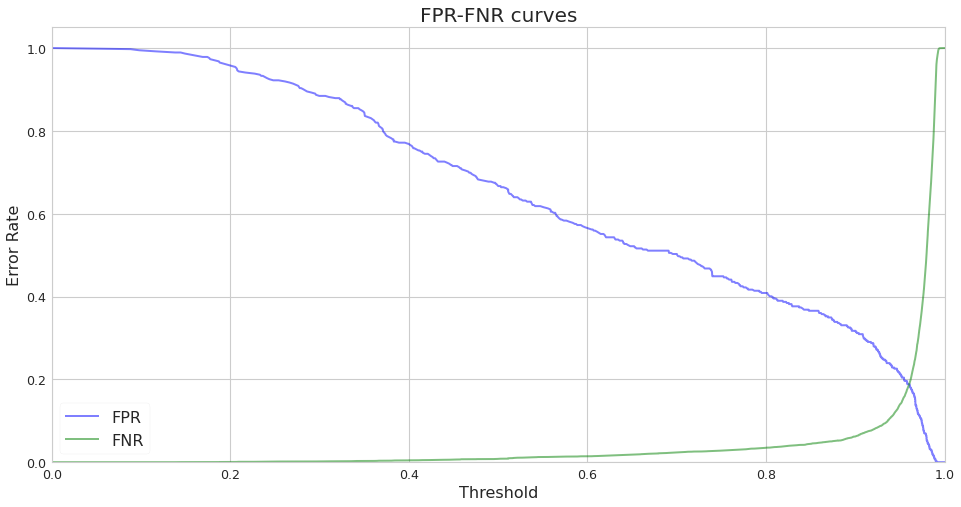

In [46]:
plt.figure(figsize=(16, 8))
style = {'alpha': 0.5, 'lw':2}

plt.plot(thresholds, fpr, color = 'blue', label = 'FPR', **style)
plt.plot(thresholds, fnr, color = 'green', label = 'FNR', **style)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
# plt.xticks(fontsize = 16)
# plt.yticks(fontsize = 16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc = 'lower left', fontsize=16)

In [47]:
from catboost.utils import select_threshold

print(select_threshold(model, val_pool, FNR=0.01))
print(select_threshold(model, val_pool, FPR=0.01))

0.5165367985887064
0.9886729205587221


we allowing FNR = 0.01, FPR = 0.01

select threshold more smart

# Metric evalation on a new dataset

In [48]:
metrics = model.eval_metrics(
    data = val_pool,
    metrics=['Logloss', 'AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

How wel our model handles new data\
for this we use eval metrics error

In [49]:
print('AUC values:\n{}'.format(np.array(metrics['AUC'])))

AUC values:
[0.5509 0.6273 0.6273 0.6279 0.6264 0.6262 0.6579 0.6579 0.6569 0.6568
 0.6567 0.6567 0.6556 0.6556 0.6556 0.6557 0.6558 0.6575 0.6587 0.6585
 0.6588 0.6587 0.7038 0.7038 0.7131 0.7263 0.7383 0.7463 0.7495 0.7655
 0.7657 0.7671 0.786  0.794  0.8025 0.8038 0.8053 0.8056 0.8125 0.8162
 0.8257 0.8275 0.829  0.8298 0.8341 0.8348 0.8357 0.8372 0.8394 0.8398
 0.841  0.8415 0.8415 0.8426 0.8426 0.8432 0.8438 0.8441 0.8445 0.846
 0.8464 0.8465 0.8469 0.8481 0.8487 0.8493 0.8498 0.8503 0.8504 0.8504
 0.8501 0.8511 0.8519 0.8522 0.8522 0.8521 0.852  0.8521 0.8522 0.8525
 0.855  0.8567 0.8592 0.8615 0.8633 0.8647 0.8659 0.8682 0.8705 0.8729
 0.8749 0.8765 0.878  0.8793 0.8802 0.8805 0.8816 0.8827 0.8829 0.8837
 0.8844 0.8848 0.8856 0.8857 0.8863 0.8872 0.8874 0.8878 0.8882 0.8885
 0.8886 0.8891 0.8894 0.8896 0.8897 0.8898 0.8901 0.8905 0.8907 0.891
 0.8914 0.8916 0.8917 0.892  0.8922 0.8923 0.8924 0.8926 0.8927 0.8929
 0.8929 0.893  0.893  0.8933 0.8934 0.8937 0.8935 0.8935 0.8933 0.8

# Feature importances

### Prediction values change

which features is more important than others\
and may be which features I can remove

In [50]:
np.array(model.get_feature_importance(prettified=True))

array([['RESOURCE', 22.41118319752206],
       ['MGR_ID', 15.989063805076912],
       ['ROLE_DEPTNAME', 15.590901306504968],
       ['ROLE_TITLE', 9.945158784498684],
       ['ROLE_ROLLUP_2', 9.558978699237155],
       ['ROLE_CODE', 8.763624880659496],
       ['ROLE_FAMILY_DESC', 7.025523887040364],
       ['ROLE_FAMILY', 5.436730661906434],
       ['ROLE_ROLLUP_1', 5.278834777553908]], dtype=object)

this tells how much prediction changes if you chnage the feature\
the other/below one will tell how much on average your loss function changes if you chnage the feature

### Loss function change

In [51]:
np.array(model.get_feature_importance(
    train_pool,
    'LossFunctionChange',
    prettified=True
))

array([['RESOURCE', 0.018123491454089306],
       ['MGR_ID', 0.01433721231400908],
       ['ROLE_DEPTNAME', 0.010254761824404386],
       ['ROLE_FAMILY_DESC', 0.007822218362481011],
       ['ROLE_TITLE', 0.007746204189302247],
       ['ROLE_CODE', 0.006989266940418128],
       ['ROLE_ROLLUP_2', 0.0036175932321223215],
       ['ROLE_ROLLUP_1', 0.002442962870817194],
       ['ROLE_FAMILY', -2.6281129950139287e-05]], dtype=object)

How much the Loss function changes if we remove the feature

##### This is time consuming to calculate

This values can be negative and positive\
negatives means featre is not good you can remove those features\
\
#### Sometimes if yor model is underfitted (i.e no. of iteration is low) then it will give negative values. which only means if we remove this feature it will be easy for the model to train
#### If you get negative following is the reason
1. May be feature is harmful
2. May be I am doing something wrong (no. of iteration low). When you overfitted it and then also tis feature is giving negative values then the feature is harmful
#### positive when they overfitted

# Shap values

In [53]:
print(model.predict_proba([x.iloc[1,:]]))    # 1st
print(model.predict_proba([x.iloc[91,:]]))   # 91th

[[0.0117 0.9883]]
[[0.332 0.668]]


In [62]:
shap_values = model.get_feature_importance(
    val_pool,
    'ShapValues'
)
expected_value = shap_values[0,-1]
shap_values = shap_values[:, :-1]
print(shap_values.shape)

(6554, 9)


In [81]:
proba = model.predict_proba([x.iloc[1,:]])[0]
raw = model.predict([x.iloc[1,:]], prediction_type='RawFormulaVal')[0]

print('Probabilities:', proba)
print('Raw formula value %.4f' % raw)
print('Probability from raw value %.4f' % sigmoid(raw))

Probabilities: [0.0117 0.9883]
Raw formula value 4.4343
Probability from raw value 0.9883


In [92]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], x_val.iloc[1,:])

for this particular object the feature with the most positive influence is ROLE_CODE, and next one is ROLE_TITLE and so on\


In [94]:
expected_value

3.4048097562110105

In [95]:
shap_values[1,:]

array([-0.3241,  0.1283,  0.0341,  0.1005,  0.004 ,  0.1312,  0.1135,
        0.0586,  0.1371])

In [96]:
x_val.iloc[1,:]

RESOURCE             25240
MGR_ID               14815
ROLE_ROLLUP_1       117961
ROLE_ROLLUP_2       118327
ROLE_DEPTNAME       118320
ROLE_TITLE          123045
ROLE_FAMILY_DESC    123107
ROLE_FAMILY         120518
ROLE_CODE           123047
Name: 19639, dtype: int64

#### now look at the next one

In [98]:
proba = model.predict_proba([x.iloc[91,:]])[0]
raw = model.predict([x.iloc[91,:]], prediction_type='RawFormulaVal')[0]

print('Probabilities:', proba)
print('Raw formula value %.4f' % raw)
print('Probability from raw value %.4f' % sigmoid(raw))

Probabilities: [0.332 0.668]
Raw formula value 0.6992
Probability from raw value 0.6680


In [99]:
import shap

shap.initjs()
shap.force_plot(expected_value, shap_values[91,:], x_val.iloc[91,:])

here ROLE_FAMILY have the largest negative influence and so on

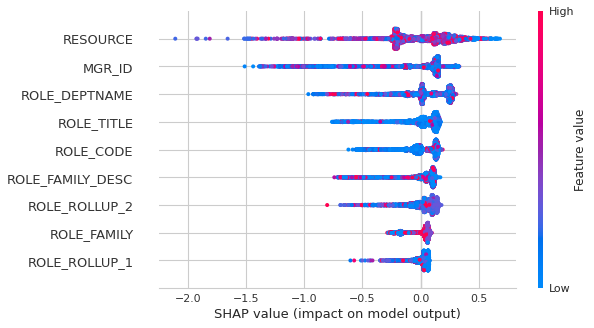

In [104]:
shap.summary_plot(shap_values, x_val)

# Snapshotting

#### somethime you want to save all the training so far. Like your model training might be interupted if pc goes to sleeep or may be server goes down, etc. In such cases it become more important to save the training that had been done so far. For this you may be snapshotting

In [109]:
# !rm 'catboost_info/snapshot.bkp'

model = CatBoostClassifier(
    iterations = 100,
    save_snapshot = True,
    snapshot_file = 'snapshot.bkp',
    snapshot_interval = 1
)

model.fit(train_pool, eval_set = val_pool, verbose = 10)

Learning rate set to 0.193326

bestTest = 0.1573067324
bestIteration = 81

Shrink model to first 82 iterations.


# Saving the model

In [110]:
model = CatBoostClassifier(iterations=100)
model.fit(train_pool, eval_set=val_pool, verbose=False)
model.save_model('catboost_model.bin')
model.save_model('catboost_model.json', format='json')

### you can save it in any formate

In [113]:
model.load_model('catboost_model.bin')
print(model.get_params())
print(model.learning_rate_)

{'iterations': 100, 'loss_function': 'Logloss', 'verbose': 0}
0.1933259964


# Hyperparameter tunning

In [122]:
tunned_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3,
    random_strength=1,
    bagging_temperature=1
)

tunned_model.fit(
    x_train, y_train,
    cat_features = cat_features,
    verbose = False,
    eval_set = (x_val, y_val),
    plot = True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# speeding up the training

In [124]:
fast_model = CatBoostClassifier(
    boosting_type='Plain',
    rsm=0.5,
    one_hot_max_size=50,
    leaf_estimation_iterations=1,
    max_ctr_complexity=1,
    iterations=100,
    learning_rate=0.3,
    bootstrap_type='Bernoulli',
    subsample=0.5
)

fast_model.fit(
    x_train, y_train,
    cat_features = cat_features,
    verbose=False,
    eval_set=(x_val, y_val),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Reducing model size

In [125]:
small_model = CatBoostClassifier(
    learning_rate=0.03,
    iterations=500,
    model_size_reg=50,
    max_ctr_complexity=1,
    ctr_leaf_count_limit=100
)
small_model.fit(
    x_train, y_train,
    cat_features = cat_features,
    verbose=False,
    eval_set=(x_val, y_val),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))